<a href="https://colab.research.google.com/github/Amitparikh1/CADS_Lending_Analysis_Workshop/blob/main/Lending_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Lending Analysis Workshop**



Attendance Link: https://forms.gle/iDzamZVt8rZQpjFG8 

## What is Lending?
Occurs when one body (usually a bank or financial institution) allows another entity to borrow something. The borrower is expected to repay the loan by a later date. In this workshop, we'll focus on banks lending to individuals, but lenders and borrowers can be anyone (individuals, businesses, governments etc.) 

## Why use Data Science in Lending?
Lending companies are successful when they loan to customers who are **able** and **willing** to repay their loans. Data Science helps lenders predict which customers will default on their loans by looking at data on things like:


*   Income
*   Marital Status
*   Age
*   Education
*   Past payment history 

Creating models based on this type of data helps them decide who to loan to and the interest rates/collateral needed. 



## Biases in Automated Lending
Some have said automated lending is the solution to the biases that our current lending process has. However, automated lending is only as unbiased as the data that is fed into it. When unmonitored, automated lending algorithms can unfairly reject applicants for reasons such as:
* Race
* Gender
* Employment type
* Geographic location


---

**For example:** If a model is trained on loan data that has an under-representation of women in it, the small sample size could lead to false inferences about female customers. 




## Counterfactual Explanations

Counterfactuals help explain individual instances of model predictions. They are not restricted to finance but rather help improve interpretability in machine learning models. In our case, they can help explain how a rejected customer could be accepted by modifying its data inputs. This is important in understanding how our models are working as they can sometimes seem like mysterious "black boxes". 


> There are various libraries to implement counterfactuals in your projects. One example: https://github.com/interpretml/DiCE




---
**For example:** The customer shown below's loan would've been approved by the model if its income was increased to $60,000 etc.

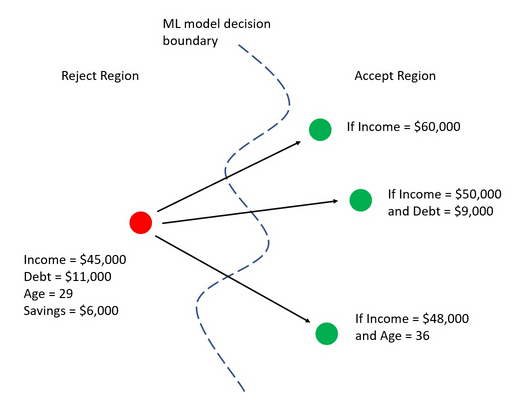



## Using Logistic Regression to predict defaultors

Following methodology from our[ ML workshop in October 2021](https://github.com/CarolinaDataScience/Workshops2021/blob/main/Intro%20to%20Machine%20Learning/%20Intro%20to%20Machine%20Learning.ipynb)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading/Cleaning Data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Read in training and test data
df_training = pd.read_csv('/content/drive/MyDrive/Data/GiveMeSomeCredit/cs-training.csv', index_col=0)
df_test = pd.read_csv('/content/drive/MyDrive/Data/GiveMeSomeCredit/cs-test.csv', index_col=0)
# OR read in using links to the data 
# df_training = pd.read_csv('https://raw.githubusercontent.com/Amitparikh1/CADS_Lending_Analysis_Workshop/main/cs-training.csv', index_col=0)
# df_test = pd.read_csv('https://raw.githubusercontent.com/Amitparikh1/CADS_Lending_Analysis_Workshop/main/cs-test.csv', index_col=0)
df_test = df_test.drop(columns=['SeriousDlqin2yrs'], errors='ignore')

# Understand what each column means (link to data dictionary: https://www.kaggle.com/c/GiveMeSomeCredit/data)
df_training.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents
1,1,0.766127,45,0.802982,9120.0,13,6,2.0
2,0,0.957151,40,0.121876,2600.0,4,0,1.0
3,0,0.658180,38,0.085113,3042.0,2,0,0.0
4,0,0.233810,30,0.036050,3300.0,5,0,0.0
5,0,0.907239,49,0.024926,63588.0,7,1,0.0


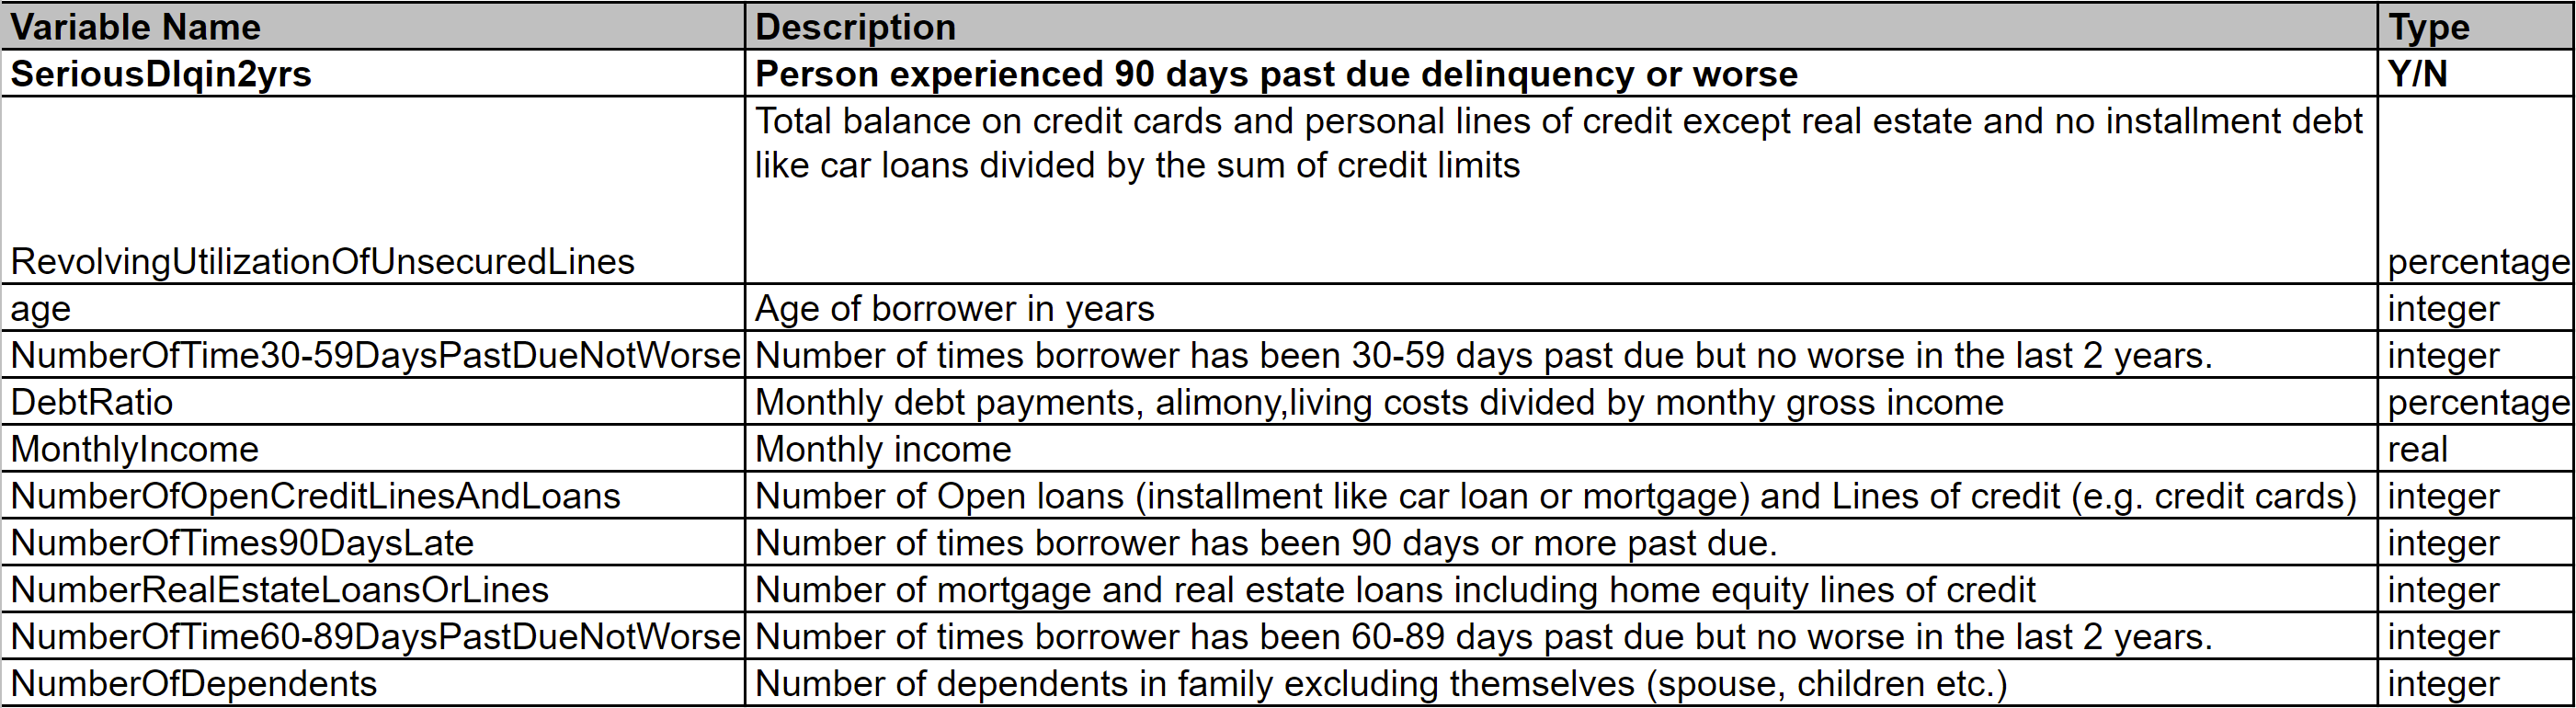

In [ ]:
# Is all of our data numeric? If not, we need to encode it
df_training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

In [ ]:
# Are there any duplicated rows that need to be dropped?
print("# of duplicates before dropping duplicates:")
print(df_training.duplicated().sum())
df_training = df_training.drop_duplicates()
print("# of duplicates after dropping duplicates:")
print(df_training.duplicated().sum())

# of duplicates before dropping duplicates:
609
# of duplicates after dropping duplicates:
0


In [ ]:
# Is there missing data that we need to impute or drop
print(df_training.isnull().sum())
df_training = df_training.dropna()
df_test = df_test.dropna()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29221
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3828
dtype: int64


Checking assumptions

In [ ]:
# Guideline: 10 cases with the least frequented outcome for each independent variable
# 10 independent variables, so we want at least 100 (10 * 10) cases where 'SeriousDlqin2yrs' is 1
len(df_training[df_training['SeriousDlqin2yrs'] == 1])

8355

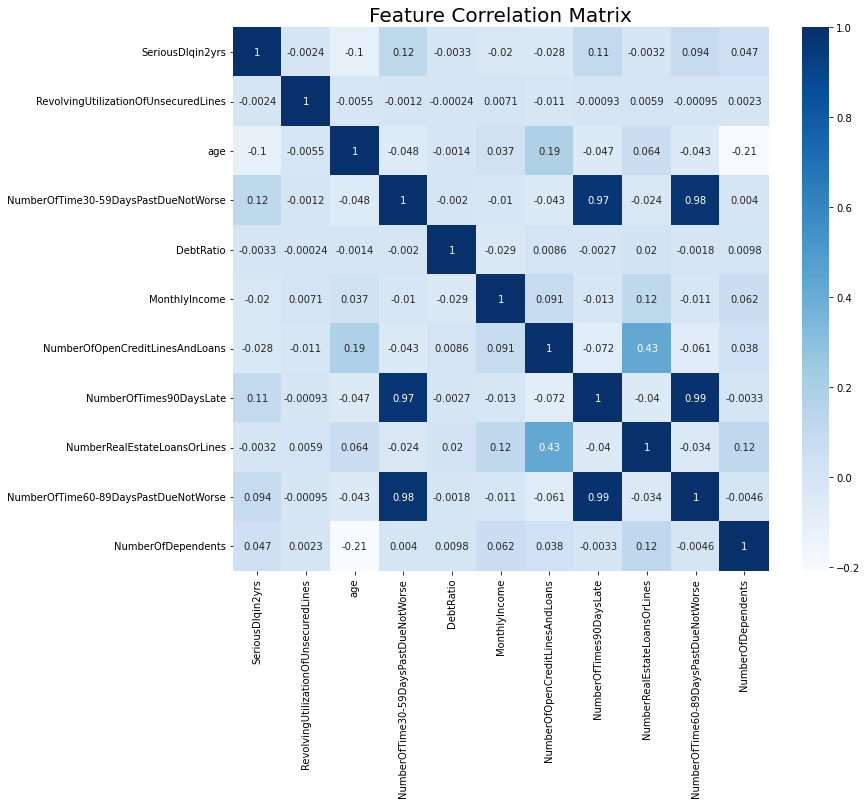

In [ ]:
# Check for multi-colinearity 
plt.figure(figsize=(12,10))
sns.heatmap(df_training.corr(), annot=True, cmap='Blues')
plt.title("Feature Correlation Matrix", fontsize=20)
plt.show()

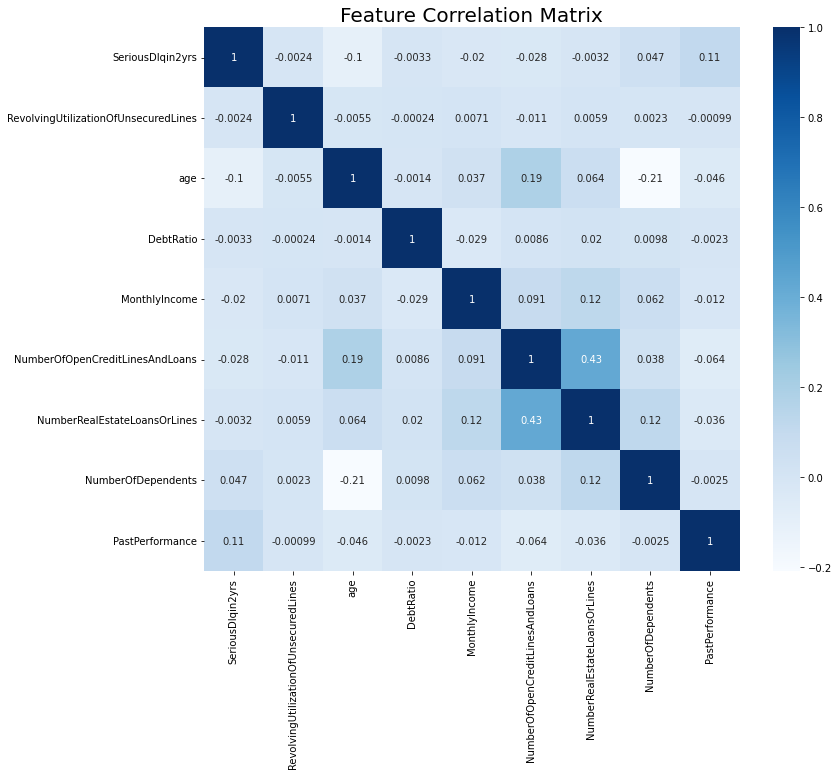

In [ ]:
# Number of times 30-59, 60-89, and 90 days late variables are all highly correlated.
# Solution: weighted linear combination of these three variables into one 'PastPerformance' variable. Number of Times 90 days late is weighted most heavily, 30-59 is weighted least heavily
df_training['PastPerformance'] = df_training['NumberOfTime30-59DaysPastDueNotWorse'] + 2*df_training['NumberOfTime60-89DaysPastDueNotWorse'] + 3*df_training['NumberOfTimes90DaysLate']
df_training = df_training.drop(columns=['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate'])
df_test['PastPerformance'] = df_test['NumberOfTime30-59DaysPastDueNotWorse'] + 2*df_test['NumberOfTime60-89DaysPastDueNotWorse'] + 3*df_test['NumberOfTimes90DaysLate']
df_test = df_test.drop(columns=['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate'])

# Check correlaion matrix after
plt.figure(figsize=(12,10))
sns.heatmap(df_training.corr(), annot=True, cmap='Blues')
plt.title("Feature Correlation Matrix", fontsize=20)
plt.show()

Fitting our Logistic Regression Model

In [ ]:
# Split training features from variable to predict
df_training_X = df_training.drop('SeriousDlqin2yrs', axis=1)
df_training_y = df_training['SeriousDlqin2yrs']

# Normalize data 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df_training_X)

df_scaled_training_X = scaler.transform(df_training_X)
df_scaled_test = scaler.transform(df_test)

# Fitting model
from sklearn.linear_model import LogisticRegression
credit_model = LogisticRegression()
credit_model.fit(df_scaled_training_X, df_training_y)

LogisticRegression()

In [ ]:
# Getting prediction for a row
row_start = 6
for col in df_test.columns:
  print(col + ": " + str(df_test[row_start:row_start + 1][col].values[0]))
if credit_model.predict(df_scaled_test[row_start:row_start + 1])[0] == 0:
   # We predict this customer will pay back their loan
   print("Customer will pay")
else:
   # We predict this customer will default on their loan
   print("Customer will default")

RevolvingUtilizationOfUnsecuredLines: 0.587778161
age: 50
DebtRatio: 1048.0
MonthlyIncome: 0.0
NumberOfOpenCreditLinesAndLoans: 5
NumberRealEstateLoansOrLines: 0
NumberOfDependents: 3.0
PastPerformance: 0
Customer will pay


In [ ]:
# Getting prediction for a row
row_start = 8
for col in df_test.columns:
  print(col + ": " + str(df_test[row_start:row_start + 1][col].values[0]))
if credit_model.predict(df_scaled_test[row_start:row_start + 1])[0] == 0:
   # We predict this customer will pay back their loan
   print("Customer will pay")
else:
   # We predict this customer will default on their loan
   print("Customer will default")

RevolvingUtilizationOfUnsecuredLines: 0.9999998999999999
age: 23
DebtRatio: 0.0
MonthlyIncome: 0.0
NumberOfOpenCreditLinesAndLoans: 0
NumberRealEstateLoansOrLines: 0
NumberOfDependents: 0.0
PastPerformance: 588
Customer will default
